In [22]:
from fastai.vision.all import *

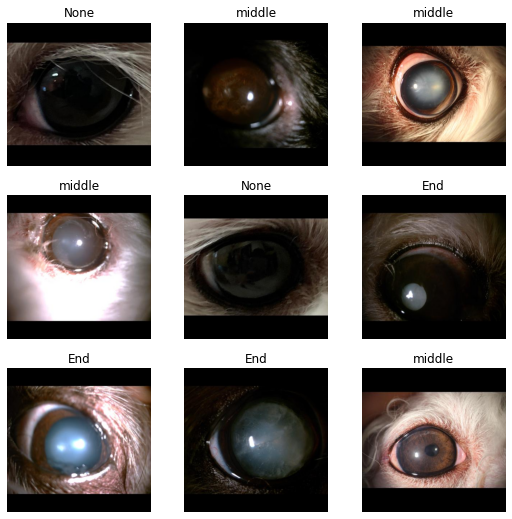

In [23]:
path = 'images/백내장/'

block = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
)

loader = block.dataloaders(path)

loader.show_batch()

In [34]:
learn = vision_learner(loader, resnet18, metrics=accuracy)

learn.fine_tune(epochs = 50)

epoch,train_loss,valid_loss,accuracy,time
0,0.793529,0.647226,0.702271,01:00


epoch,train_loss,valid_loss,accuracy,time
0,0.572991,0.513152,0.776930,01:18
1,0.437079,0.463959,0.806176,01:18
2,0.329107,0.442434,0.820890,01:18
3,0.221977,0.454999,0.832516,01:18
4,0.133995,0.528858,0.832516,01:18
5,0.119429,0.608779,0.815077,01:18
6,0.110703,0.611579,0.837965,01:18
7,0.116104,0.667403,0.825613,01:18
8,0.103387,0.619644,0.824886,01:18
9,0.108524,0.695308,0.817439,01:18


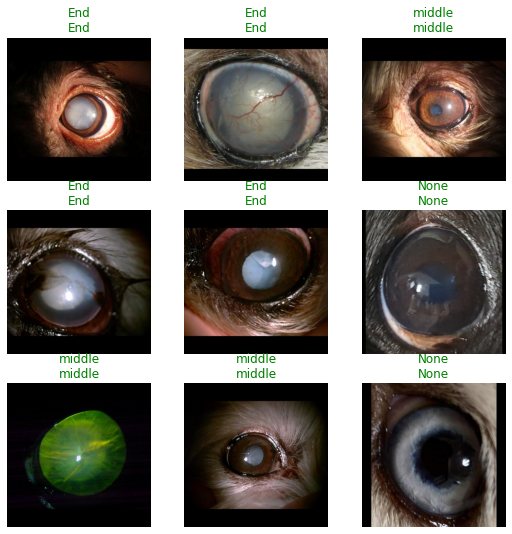

In [35]:
learn.show_results()

torch.Size([1, 3, 400, 400]) torch.Size([1, 3, 400, 400])


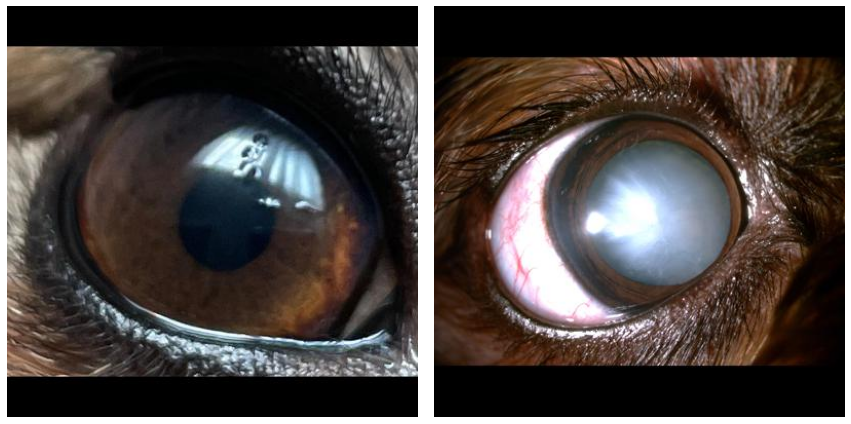

In [36]:
neg_path = 'images/백내장/None/crop_D0_2a5940ad-60a5-11ec-8402-0a7404972c70.jpg'
pos_path = 'images/백내장/End/crop_D0_0dc420f8-60a5-11ec-8402-0a7404972c70.jpg'

test_loader = loader.test_dl([neg_path, pos_path])

neg_x, pos_x = next(iter(test_loader))[0]

neg_x = neg_x.unsqueeze(0)
pos_x = pos_x.unsqueeze(0)

print(neg_x.shape, pos_x.shape)

neg_img = Image.open(neg_path)
pos_img = Image.open(pos_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(neg_img)
ax[0].axis('off')
ax[1].imshow(pos_img)
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [27]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o):
        self.stored = o.detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)  
    def hook_func(self, m, gi, go):
        self.stored = go[0].detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

torch.Size([25, 25])


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1315: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


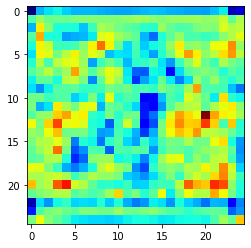

In [ ]:
def get_gradcam(x, location=-1):
    with HookBwd(learn.model[0][location]) as hookg:
        with Hook(learn.model[0][location]) as hook:
            output = learn.model.eval()(x.cuda())
            idx = torch.argmax(output)
            act = hook.stored
        output[0, idx].backward()
        grad = hookg.stored

    w = grad[0].mean(dim=[1, 2], keepdim=True)
    heatmap = (w * act[0]).sum(0).detach().cpu()

    return heatmap

heatmap = get_gradcam(pos_x, location=-2)

print(heatmap.shape)
plt.imshow(heatmap, cmap='jet')
plt.show()

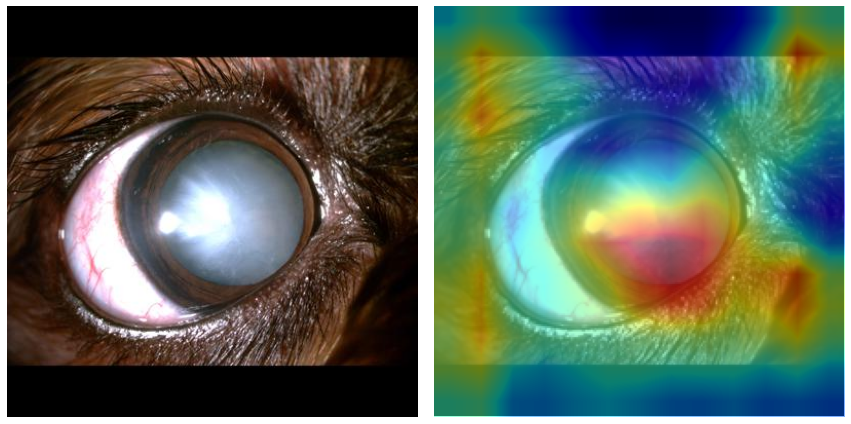

In [32]:
img = Image.open(pos_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')

heatmap_image = img.copy()
heatmap_image = heatmap_image.resize((224, 224))  # heatmap 이미지 크기 조정

ax[1].imshow(heatmap_image)
ax[1].imshow(heatmap.cpu(), alpha=0.5, extent=(0, 224, 224, 0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()

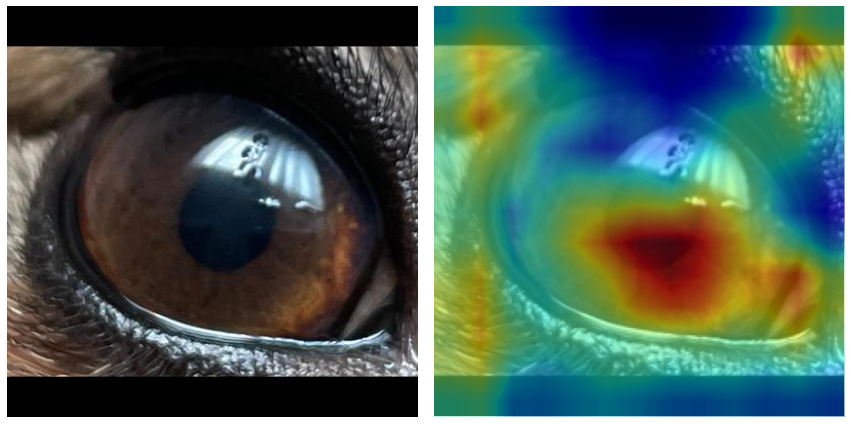

In [33]:
img = Image.open(neg_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')

heatmap_image = img.copy()
heatmap_image = heatmap_image.resize((224, 224))  # heatmap 이미지 크기 조정

ax[1].imshow(heatmap_image)
ax[1].imshow(heatmap.cpu(), alpha=0.5, extent=(0, 224, 224, 0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()